# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from sklearn.decomposition import PCA
import itertools
from tqdm import tqdm
import json
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from data_generation.methods.algorithmic.brownian_motion import brownian_motion

from utils import load_time_series, plot_multiple_time_series_attributes, split_data_into_sequences
from metrics import visualize

from baseline_model.LSTM import LSTM, train_model

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

## 1 Load Baseline Model and Data

In [5]:
data_real = load_time_series(REAL_DATA_FOLDER/'AAPL_22_23_real.csv')
data_syn = load_time_series(SYNTHETIC_DATA_FOLDER/'AAPL_22_23_syn.csv')

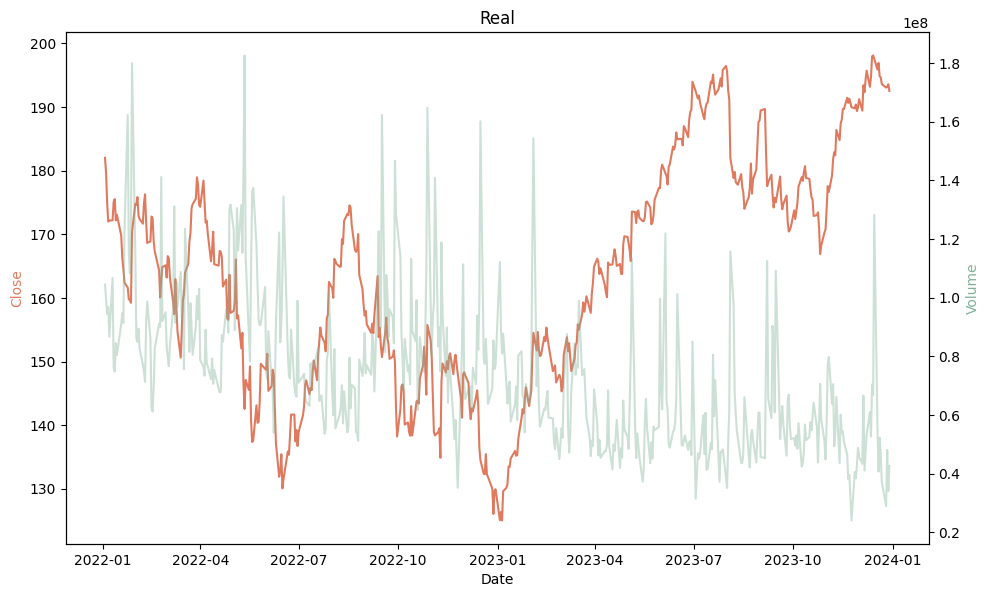

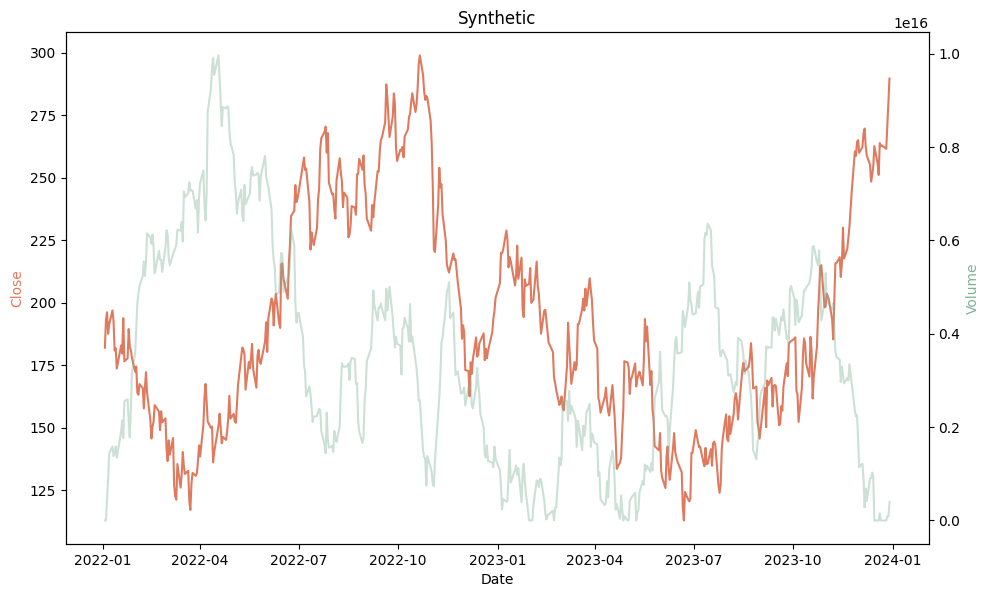

In [6]:
plot_multiple_time_series_attributes(data_real, title="Real")
plot_multiple_time_series_attributes(data_syn, title="Synthetic")

## 2 Train and Test Baseline Model

### 2.1 Train on Real, Test on Synthetic

### 2.2 Train on Synthetic, Test on Real

## 3 Visualize Synthetic vs Real Data

In [7]:
# convert data into numpy arrays
data_real = data_real[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].to_numpy()
data_syn = data_syn[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].to_numpy()

# split data into sequences
data_real = split_data_into_sequences(data_real, seq_len=24)
data_syn = split_data_into_sequences(data_syn, seq_len=24)

Preprocessing data. Shape: (477, 24, 6)
Data has been preprocessed. Shape: (477, 144)


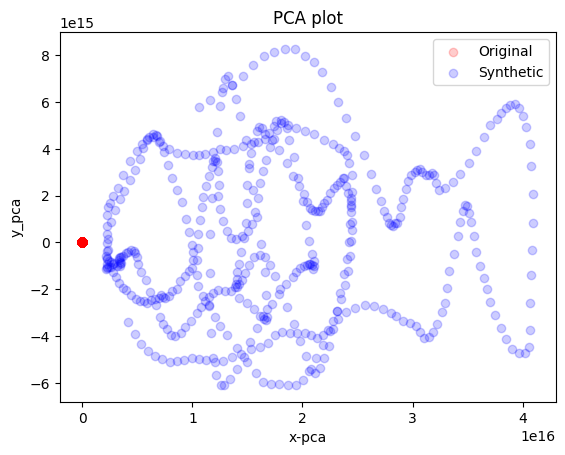

Preprocessing data. Shape: (477, 24, 6)
Data has been preprocessed. Shape: (477, 144)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 954 samples in 0.001s...
[t-SNE] Computed neighbors for 954 samples in 0.290s...
[t-SNE] Computed conditional probabilities for sample 954 / 954
[t-SNE] Mean sigma: 57083417.284983
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.297630
[t-SNE] KL divergence after 300 iterations: 1.661450
t-SNE results shape: (954, 2)


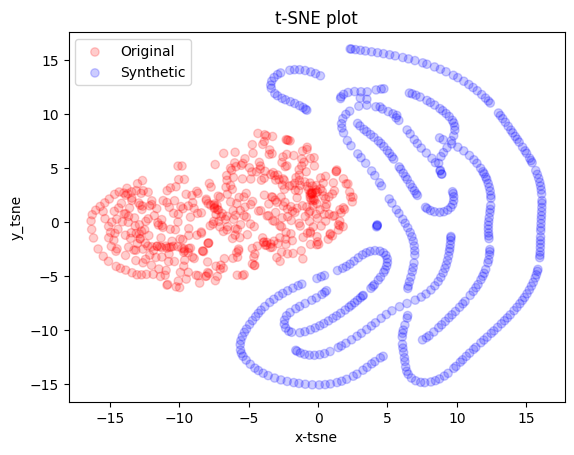

In [8]:
visualize(data_real, data_syn, metric='pca')
visualize(data_real, data_syn, metric='tsne')

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.